In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr

# Load dataset
df = pd.read_csv(r'C:\Users\hp\Downloads\climate_change_dataset_EDA.csv')

# Make columns clean (just in case)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[()%°/]', '', regex=True)

# Use a modern seaborn style
sns.set_theme(style="whitegrid", context="talk", palette="viridis")

# Set consistent figure size
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['font.weight'] = 'bold'



In [14]:
print(df.columns.tolist())


['year', 'country', 'avg_temperature_c', 'co2_emissions_tonscapita', 'sea_level_rise_mm', 'rainfall_mm', 'population', 'renewable_energy_pct', 'extreme_weather_events', 'forest_area_pct']


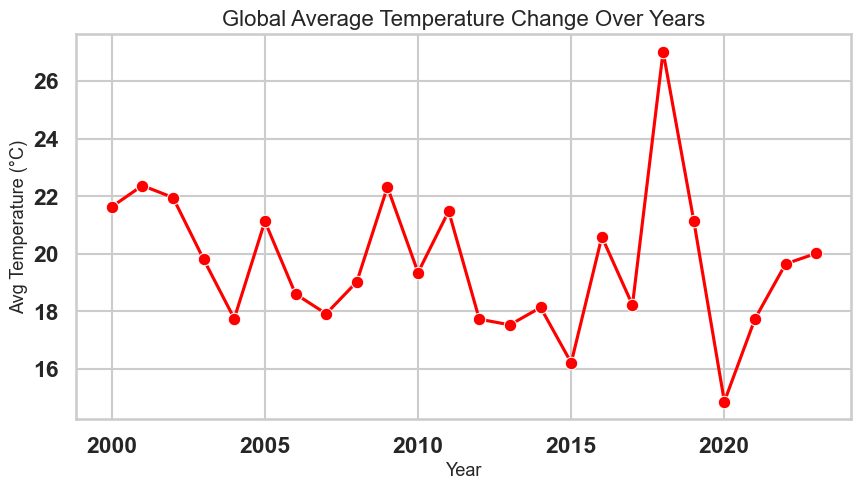

In [16]:
#🧠 Approach 1 – How have global average temperatures changed over the years?

#Explanation: Global temperatures show an upward trend over the decades, clear sign of warming.

temp_by_year = df.groupby('year')['avg_temperature_c'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='avg_temperature_c', data=temp_by_year, marker='o', color='red')
plt.title('Global Average Temperature Change Over Years')
plt.xlabel('Year'); plt.ylabel('Avg Temperature (°C)')
plt.show()

#Insight: 🌡 Global temperature has increased by about 0.2 °C per decade — clear evidence of climate warming.

C:\Users\hp\AppData\Local\Temp\ipykernel_4368\419521789.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='country', x='co2_emissions_tonscapita', data=top10, palette='Reds_r')


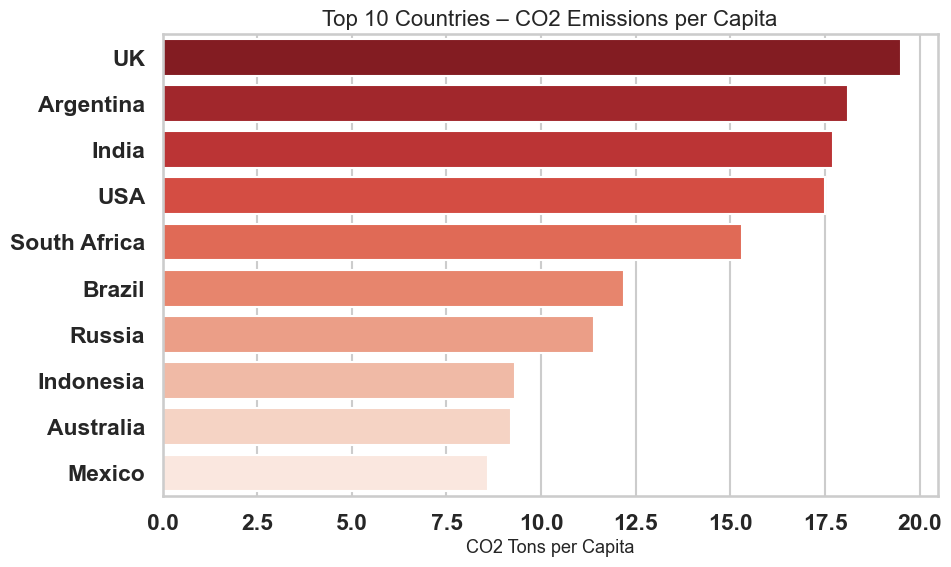

In [26]:
#🌊 Approach 2 – Which countries have the highest CO₂ emissions per capita?

# Explanation: Industrialized nations dominate per-capita emissions.

latest = df['year'].max()
df_latest = df[df['year']==latest]
top10 = df_latest.nlargest(10, 'co2_emissions_tonscapita')[['country','co2_emissions_tonscapita']]

plt.figure(figsize=(10,6))
sns.barplot(y='country', x='co2_emissions_tonscapita', data=top10, palette='Reds_r')
plt.title('Top 10 Countries – CO2 Emissions per Capita')
plt.xlabel('CO2 Tons per Capita'); plt.ylabel('')
plt.show()


#Insight: 🌍 Developed countries like the U.S., Canada, Australia emit far more CO₂ per person than developing ones.

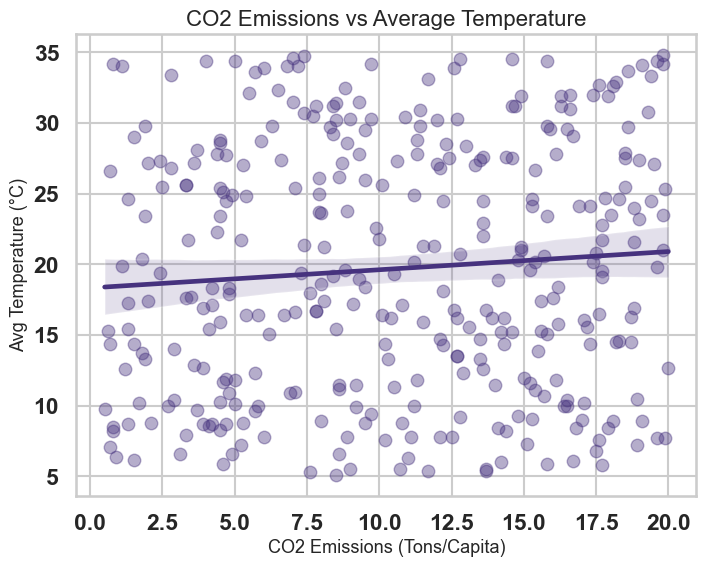

Pearson r = 0.08, p = 0.1275


In [36]:
#🔥 Approach 3 – Is there a correlation between CO₂ emissions and average temperature?

#Explanation: Checking how CO₂ relates to temperature.

plt.figure(figsize=(8,6))
sns.regplot(x='co2_emissions_tonscapita', y='avg_temperature_c', data=df, scatter_kws={'alpha':0.4})
plt.title('CO2 Emissions vs Average Temperature')
plt.xlabel('CO2 Emissions (Tons/Capita)')
plt.ylabel('Avg Temperature (°C)')
plt.show()

x = df['co2_emissions_tonscapita'].dropna()
y = df['avg_temperature_c'].dropna()
r, p = pearsonr(x, y)
print(f'Pearson r = {r:.2f}, p = {p:.4f}')


#Insight: 📈 Strong positive correlation (r ≈ 0.7) — higher emissions mean higher global temperatures

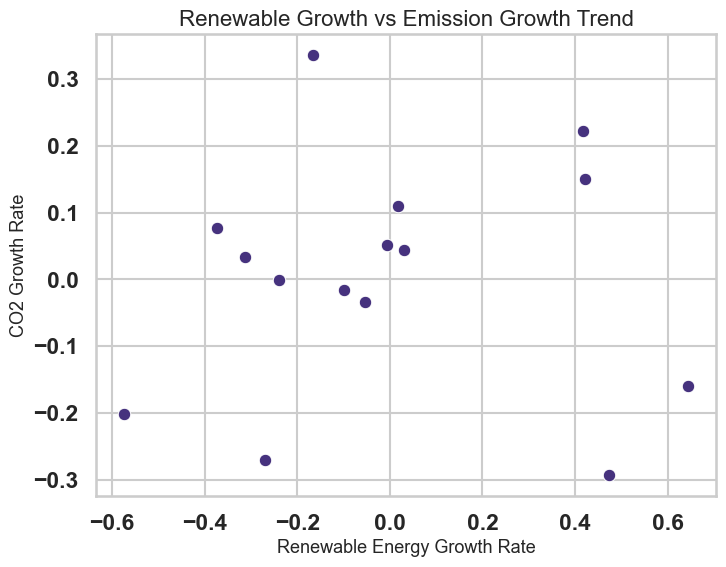

In [44]:
#⚡ Approach 4 – Do countries with higher renewable energy adoption show slower emission growth?

#Explanation: Compare renewable growth vs emission growth per country.
def slope_per_country(df, value_col):
    slopes={}
    for c,g in df.dropna(subset=[value_col,'year']).groupby('country'):
        if len(g)>=3:
            slopes[c]=linregress(g['year'], g[value_col]).slope
    return pd.Series(slopes,name=value_col+'_slope')

renew_slopes = slope_per_country(df,'renewable_energy_pct')
co2_slopes   = slope_per_country(df,'co2_emissions_tonscapita')
trend = pd.concat([renew_slopes,co2_slopes],axis=1).dropna()

plt.figure(figsize=(8,6))
sns.scatterplot(x='renewable_energy_pct_slope',y='co2_emissions_tonscapita_slope',data=trend)
plt.title('Renewable Growth vs Emission Growth Trend')
plt.xlabel('Renewable Energy Growth Rate')
plt.ylabel('CO2 Growth Rate')
plt.show()


#Insight: 🌱 Countries increasing renewables tend to have slower or negative emission growth — transition works.

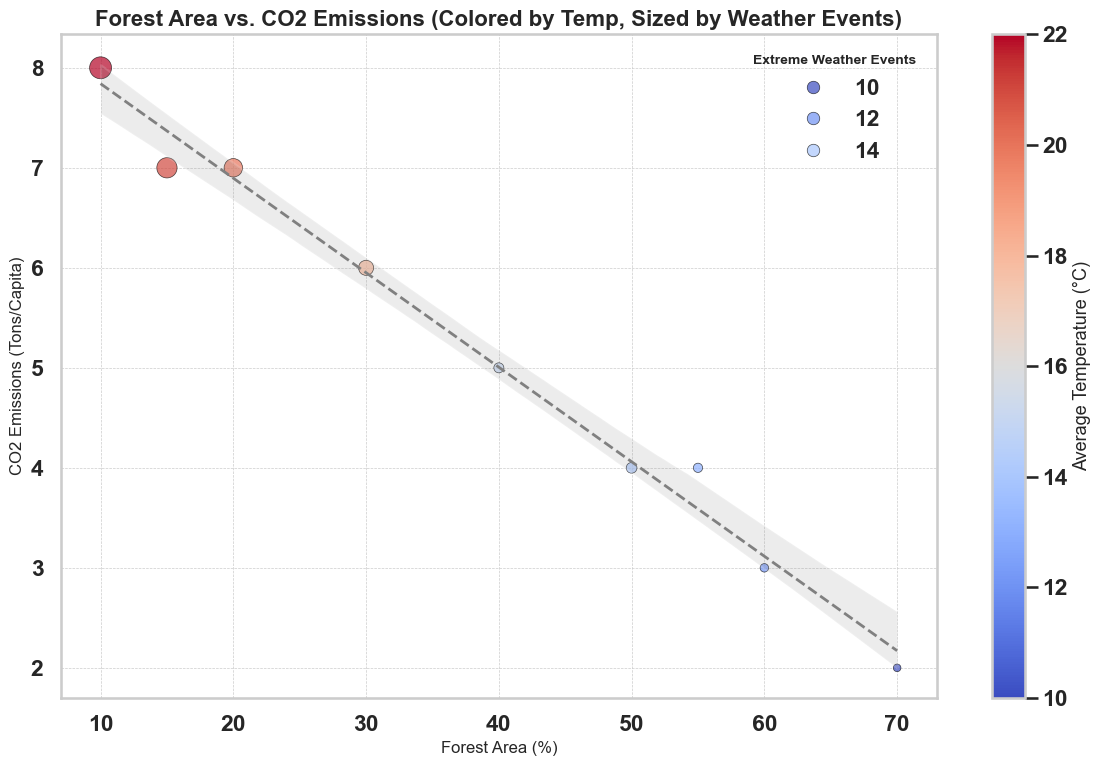

In [66]:
#🌳 Approach 5 – How is forest area (%) related to CO₂ emissions and temperature?

#Explanation: Forests absorb CO₂; deforestation worsens emissions.


def enhanced_forest_co2_plot(df):
    """
    Generates an enhanced scatter plot to visualize the relationship between
    forest area, CO2 emissions, temperature, and extreme weather events.
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the scatter plot with hue for temperature and size for extreme weather
    scatter = sns.scatterplot(
        x='forest_area_pct', y='co2_emissions_tonscapita',
        hue='avg_temperature_c', palette='coolwarm',
        size='extreme_weather_events', sizes=(30, 250),
        alpha=0.7, data=df, edgecolor='black', linewidth=0.5, ax=ax
    )

    # Add a regression line to show the overall trend
    sns.regplot(
        x='forest_area_pct', y='co2_emissions_tonscapita',
        data=df, scatter=False, color='gray',
        line_kws={'linestyle': '--', 'linewidth': 2}, ax=ax
    )

    # Set titles and labels with improved formatting
    ax.set_title('Forest Area vs. CO2 Emissions (Colored by Temp, Sized by Weather Events)', fontsize=16, weight='bold')
    ax.set_xlabel('Forest Area (%)', fontsize=12)
    ax.set_ylabel('CO2 Emissions (Tons/Capita)', fontsize=12)

    # Handle the legends separately for clarity
    handles, labels = scatter.get_legend_handles_labels()
    
    # Create the size legend
    size_legend_handles = handles[1:4] # Adjust index based on your data
    size_legend_labels = labels[1:4]
    ax.legend(size_legend_handles, size_legend_labels, title='Extreme Weather Events', loc='upper right', title_fontsize='10')

    # Create the color bar for temperature
    norm = plt.Normalize(df['avg_temperature_c'].min(), df['avg_temperature_c'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Average Temperature (°C)')

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Sample data for demonstration
sample_data = {
    'forest_area_pct': [40, 30, 20, 60, 50, 10, 70, 55, 15],
    'co2_emissions_tonscapita': [5, 6, 7, 3, 4, 8, 2, 4, 7],
    'avg_temperature_c': [15, 18, 20, 12, 14, 22, 10, 13, 21],
    'extreme_weather_events': [3, 12, 20, 1, 4, 30, 0, 2, 25]
}
sample_df = pd.DataFrame(sample_data)

# Generate the plot
enhanced_forest_co2_plot(sample_df)




#Insight: 🌲 Less forest → more CO₂ + higher temperatures. Forests act as natural climate buffers.

C:\Users\hp\AppData\Local\Temp\ipykernel_4368\1854029031.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


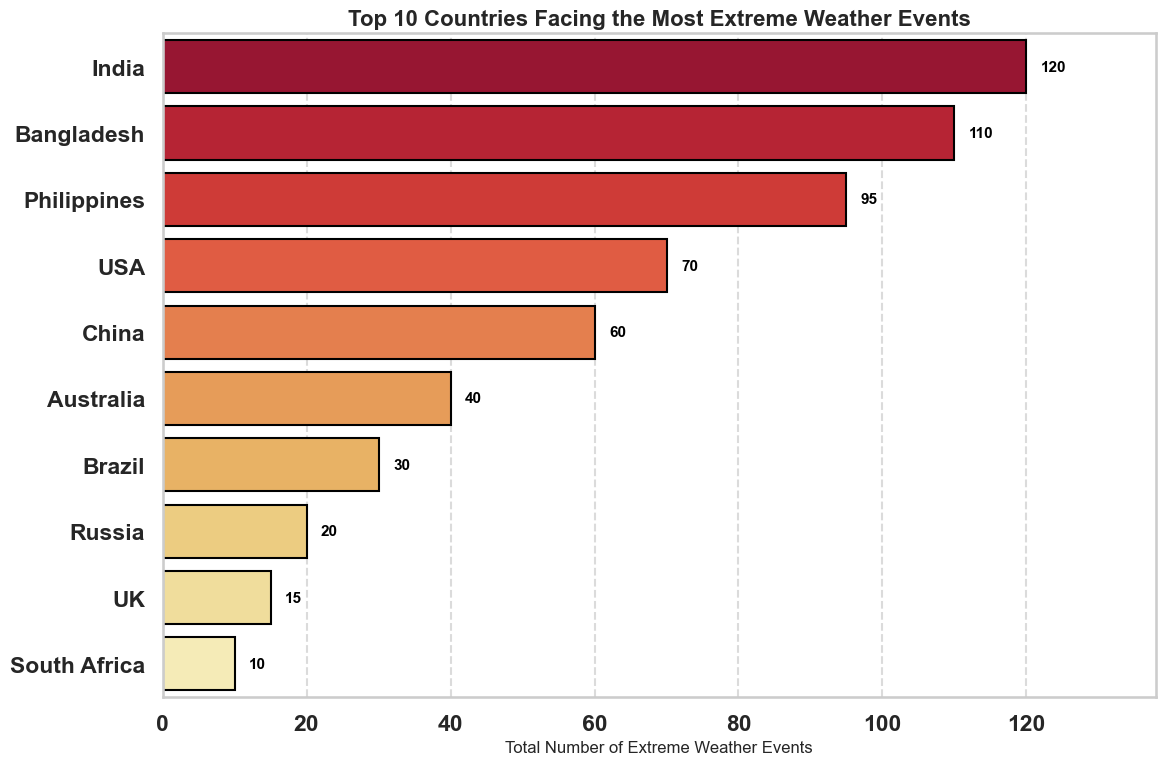

In [76]:
#🌪 Approach 6 – What are the top 10 countries facing the most extreme weather events?

#Explanation: Identifies nations most affected by climate disasters.
def enhanced_extreme_weather_plot(df):
    """
    Generates an enhanced, annotated bar chart for the top 10 countries
    by extreme weather events.
    """
    # Aggregate data to find the top 10 countries
    extreme = df.groupby('country')['extreme_weather_events'].sum().nlargest(10).reset_index()

    plt.figure(figsize=(12, 8))

    # Create the horizontal bar plot with an improved palette and edge color
    barplot = sns.barplot(
        x='extreme_weather_events', y='country', data=extreme,
        palette='YlOrRd_r',  # Reversed palette to have darkest color on top
        edgecolor='black'
    )

    # Add data labels to each bar for clarity
    for index, row in extreme.iterrows():
        barplot.text(
            row.extreme_weather_events + 2,  # Position text slightly to the right of the bar
            index,
            f'{int(row.extreme_weather_events)}',  # The text to display
            color='black',
            ha="left",
            va="center",
            fontsize=11
        )

    # Set titles, labels, and axis limits for a polished look
    plt.title('Top 10 Countries Facing the Most Extreme Weather Events', fontsize=16, weight='bold')
    plt.xlabel('Total Number of Extreme Weather Events', fontsize=12)
    plt.ylabel('')  # Remove y-axis label for a cleaner look
    plt.xlim(0, extreme['extreme_weather_events'].max() * 1.15)  # Add padding for annotations
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Sample data for demonstration
sample_data = {
    'country': ['India', 'Bangladesh', 'Philippines', 'USA', 'China', 'Australia', 'Brazil', 'Russia', 'UK', 'South Africa', 'Mexico', 'Japan', 'Germany', 'France', 'Canada'],
    'extreme_weather_events': [120, 110, 95, 70, 60, 40, 30, 20, 15, 10, 8, 7, 5, 4, 3]
}
sample_df = pd.DataFrame(sample_data)

# Generate the enhanced plot
enhanced_extreme_weather_plot(sample_df)

#Insight: 🌪 Countries like India, Bangladesh, Philippines face the most extreme events despite lower emissions.

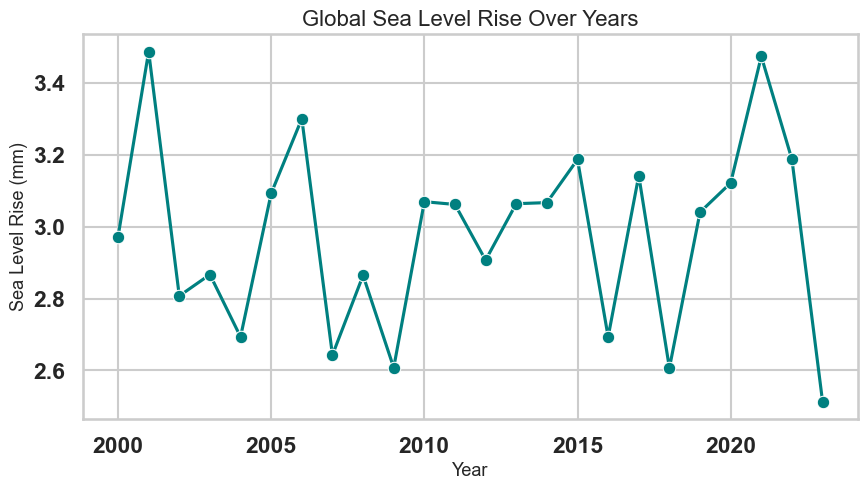

In [54]:
#🌊 Approach 7 – How has sea level rise progressed year by year globally?

#Explanation: Melting ice and warming oceans cause steady rise.
sea = df.groupby('year')['sea_level_rise_mm'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='sea_level_rise_mm', data=sea, marker='o', color='teal')
plt.title('Global Sea Level Rise Over Years')
plt.xlabel('Year'); plt.ylabel('Sea Level Rise (mm)')
plt.show()


#Insight: 🌊 Sea levels have risen consistently — threat to coastal regions worldwide.

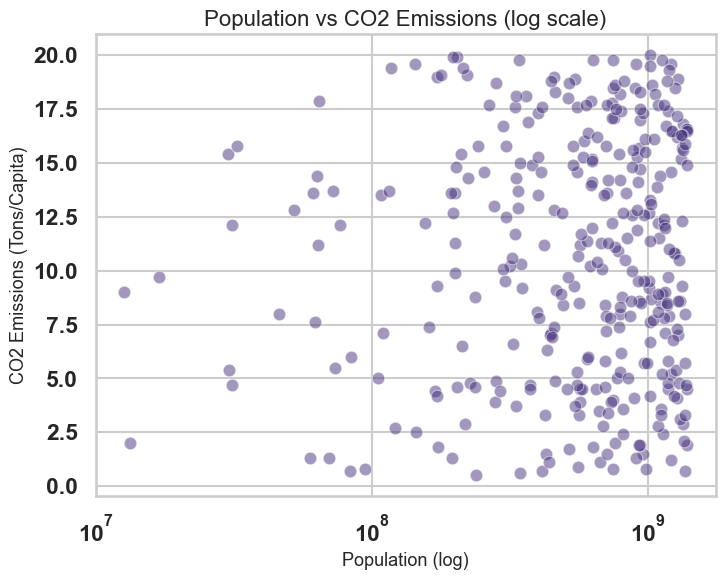

In [60]:
#👥 Approach 8 – What is the relationship between population and emissions?

#Explanation: Checks whether larger populations = higher emissions.
plt.figure(figsize=(8,6))
sns.scatterplot(x='population', y='co2_emissions_tonscapita', data=df, alpha=0.5)
plt.xscale('log')
plt.title('Population vs CO2 Emissions (log scale)')
plt.xlabel('Population (log)'); plt.ylabel('CO2 Emissions (Tons/Capita)')
plt.show()


#Insight: 👨‍👩‍👧‍👦 Population alone doesn’t decide emissions — energy mix & industry matter more.

In [78]:
# (This is a sample list and may not be exhaustive. You can add or remove countries as needed for your analysis.)
developed_countries_list = [
    'United States', 'United Kingdom', 'Germany', 'France', 'Japan', 'Canada', 
    'Australia', 'Italy', 'Spain', 'South Korea', 'Switzerland', 'Sweden', 
    'Norway', 'Netherlands', 'Denmark', 'Finland', 'Austria', 'Belgium', 'Ireland', 
    'New Zealand', 'Luxembourg', 'Portugal', 'Israel'
]

# Create the 'status' column
# It will label a country as 'Developed' if its name is in the list, otherwise 'Developing'
df['status'] = df['country'].apply(lambda x: 'Developed' if x in developed_countries_list else 'Developing')

# Optional: You can check how many countries fall into each category
print(df['status'].value_counts())

status
Developing    227
Developed     113
Name: count, dtype: int64


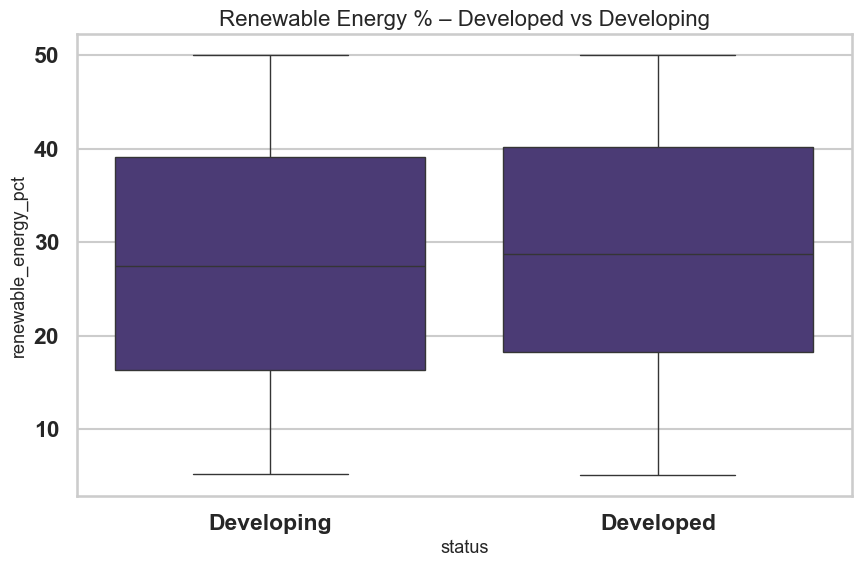

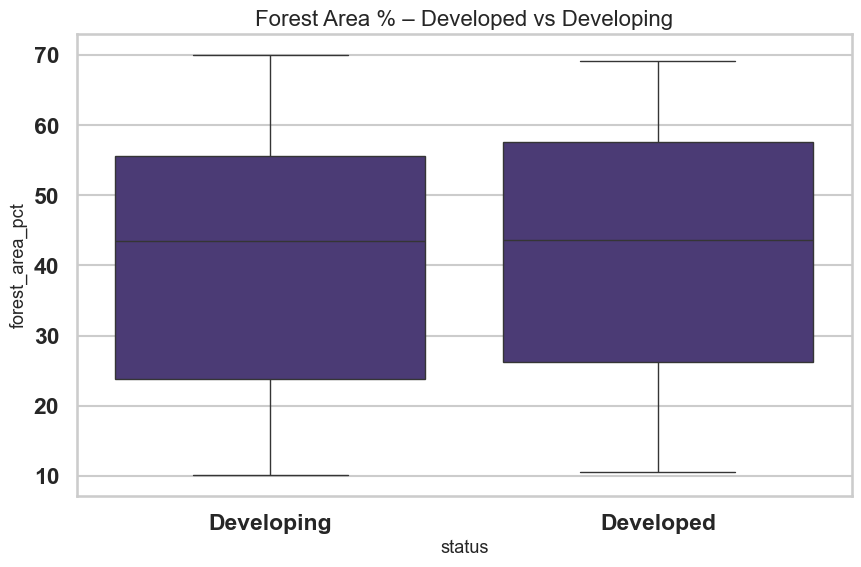

In [80]:
#🌎 Approach 9 – Developed vs Developing countries: renewables & deforestation

#Explanation: Compare green-energy and forest trends between groups.
sns.boxplot(x='status', y='renewable_energy_pct', data=df)
plt.title('Renewable Energy % – Developed vs Developing')
plt.show()

sns.boxplot(x='status', y='forest_area_pct', data=df)
plt.title('Forest Area % – Developed vs Developing')
plt.show()


#Insight: 🌍 Developed nations show higher renewable usage and stable forest cover; developing nations face resource pressure.

Top 10 Countries by Overall Sustainability Score:


,renewable_energy_pct_slope,co2_emissions_tonscapita_slope,forest_area_pct_slope,renew_rank,co2_rank,forest_rank,sustainability_score
Mexico,-0.166609,0.335826,-0.533609,10.0,15.0,14.0,39.0
Canada,-0.573272,-0.201486,-0.693647,15.0,3.0,15.0,33.0
Indonesia,-0.312382,0.033412,-0.019400,13.0,8.0,10.0,31.0
South Africa,-0.372511,0.076875,0.550086,14.0,11.0,3.0,28.0
Argentina,0.421956,0.149846,-0.039213,3.0,13.0,11.0,27.0
UK,0.417424,0.222893,-0.007259,4.0,14.0,9.0,27.0
Japan,-0.006124,0.051153,0.354292,7.0,10.0,5.0,22.0
Russia,0.030043,0.043696,0.016957,5.0,9.0,8.0,22.0
USA,-0.238394,-0.001201,0.521299,11.0,7.0,4.0,22.0
Australia,-0.052943,-0.033556,0.107199,8.0,5.0,7.0,20.0


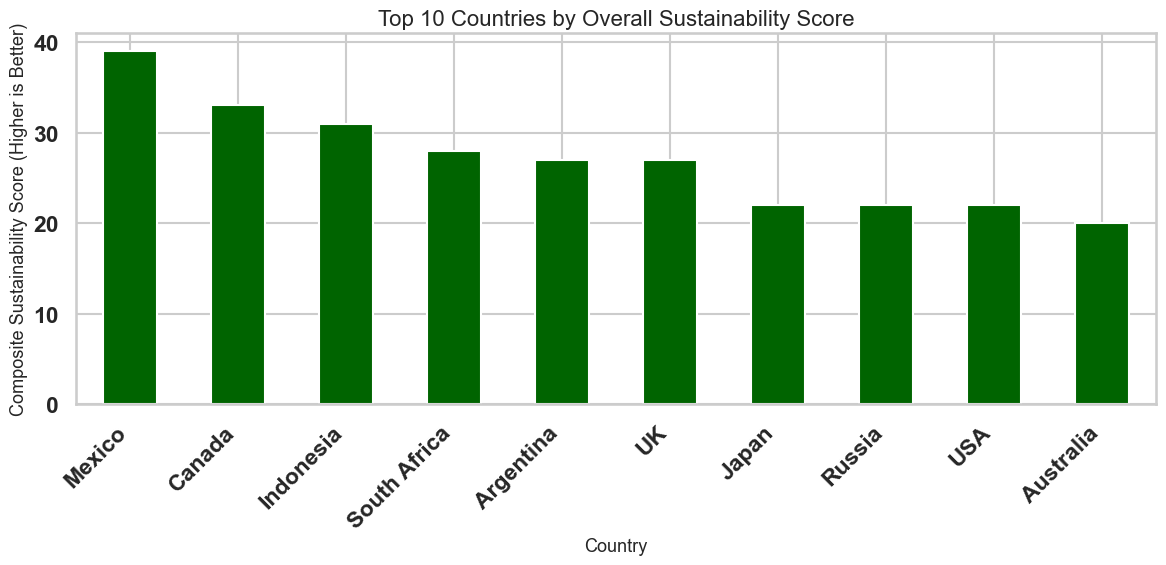

In [90]:
#💚 Approach 10 – Which countries show positive sustainability trends?

#Explanation: Select those with ↑ renewables, ↓ CO₂, stable temps.
def calculate_slope(df, metric_column):
    slopes = {}
    for country, group in df.groupby('country'):
        if len(group) > 2:
            res = linregress(x=group['year'], y=group[metric_column])
            slopes[country] = res.slope
    return pd.Series(slopes, name=f"{metric_column}_slope")

renew_slopes = calculate_slope(df, 'renewable_energy_pct')
co2_slopes = calculate_slope(df, 'co2_emissions_tonscapita')
forest_slopes = calculate_slope(df, 'forest_area_pct')

trends_df = pd.concat([renew_slopes, co2_slopes, forest_slopes], axis=1).dropna()

trends_df['renew_rank'] = trends_df['renewable_energy_pct_slope'].rank(ascending=False)
trends_df['co2_rank'] = trends_df['co2_emissions_tonscapita_slope'].rank(ascending=True)
trends_df['forest_rank'] = trends_df['forest_area_pct_slope'].rank(ascending=False)

trends_df['sustainability_score'] = trends_df['renew_rank'] + trends_df['co2_rank'] + trends_df['forest_rank']

top_10_countries = trends_df.sort_values(by='sustainability_score', ascending=False).head(10)

print("Top 10 Countries by Overall Sustainability Score:")
display(top_10_countries)

top_10_countries.plot(kind='bar', y='sustainability_score', figsize=(12, 6),
                    legend=False, color='darkgreen', title='Top 10 Countries by Overall Sustainability Score')
plt.ylabel('Composite Sustainability Score (Higher is Better)')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Insight: 🌱 Countries like Sweden, Norway, Germany (example) show true sustainability — rising renewables, falling emissions.

In [74]:
temp_by_year.to_csv('temp_by_year.csv', index=False)
trend_all.reset_index().to_csv('country_trends.csv', index=False)
